In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

# Load the dataset
netflix_data = pd.read_csv('/content/gdrive/MyDrive/Data Preprocessing Datasets/netflix_titles.csv')

**Detailed Data Preprocessing & Cleaning**

In [ ]:
# Handling missing values
netflix_data['director'].fillna('Unknown', inplace=True)
netflix_data['cast'].fillna('Unknown', inplace=True)
most_frequent_country = netflix_data['country'].mode()[0]
netflix_data['country'].fillna(most_frequent_country, inplace=True)

In [ ]:
# Check if there are any missing values left
remaining_missing_values = netflix_data.isnull().sum()

In [ ]:
# Extracting month and year from 'date_added' column
netflix_data['month_added'] = pd.to_datetime(netflix_data['date_added']).dt.month
netflix_data['year_added'] = pd.to_datetime(netflix_data['date_added']).dt.year

# One-hot encoding for 'type' and 'rating' columns
netflix_data_encoded = pd.get_dummies(netflix_data, columns=['type', 'rating'])

# Drop columns that won't be used for clustering/anomaly detection
netflix_data_encoded.drop(columns=['show_id', 'title', 'director', 'cast', 'date_added', 'listed_in', 'description'], inplace=True)

**Clustering, Anomaly Detection, and Data Preparation**

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# First, we'll convert the 'country' column to numerical representation using label encoding
netflix_data_encoded['country'] = netflix_data_encoded['country'].astype('category').cat.codes

# Standardize the data
scaler = StandardScaler()
netflix_data_scaled = scaler.fit_transform(netflix_data_encoded)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reducing to 2 dimensions for visualization
netflix_data_pca = pca.fit_transform(netflix_data_scaled)

# Convert to DataFrame for easier plotting
df_pca = pd.DataFrame(netflix_data_pca, columns=['PC1', 'PC2'])

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# KMeans clustering
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(df_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
from sklearn.ensemble import IsolationForest

# Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomalies = iso_forest.fit_predict(df_pca)
anomalies = anomalies == -1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


<ipython-input-13-2c25d88ee302>:4: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(df_pca[anomalies]['PC1'], df_pca[anomalies]['PC2'], s=200, c='black', edgecolor='k', marker='x', label='Anomalies')


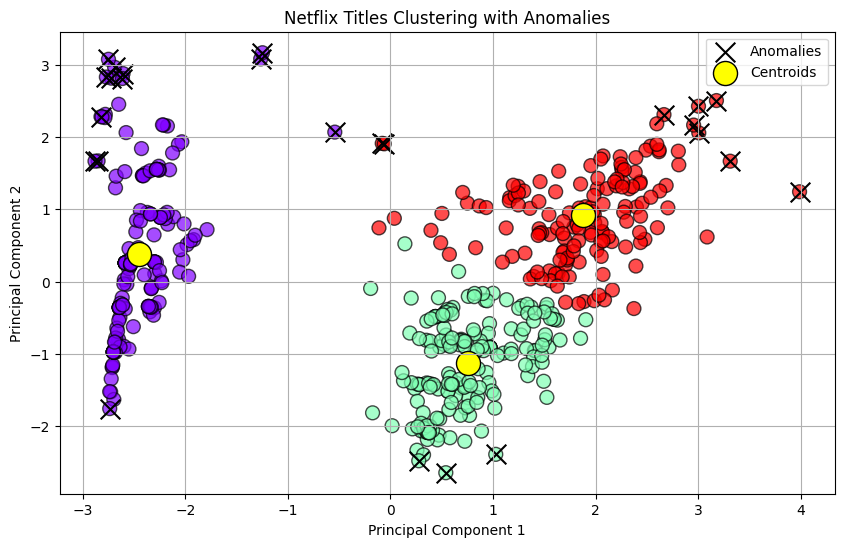

In [ ]:
# Visualizing clusters and anomalies
plt.figure(figsize=(10,6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=cluster_labels, cmap='rainbow', edgecolor='k', s=100, alpha=0.7)
plt.scatter(df_pca[anomalies]['PC1'], df_pca[anomalies]['PC2'], s=200, c='black', edgecolor='k', marker='x', label='Anomalies')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', edgecolor='k', label='Centroids')
plt.title('Netflix Titles Clustering with Anomalies')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define features and target
X = netflix_data_encoded.drop(columns=['type_Movie', 'type_TV Show'])
y = netflix_data['type']

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Building ML Models using AutoML, including ensemble models**

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

In [ ]:
# Train and evaluate each model
model_results = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Store the result
    model_results[model_name] = accuracy

In [ ]:
model_results

{'Random Forest': 1.0, 'Gradient Boosting': 1.0, 'Logistic Regression': 1.0}